In [1]:
#FOR TESTING ONLY
#since the code that will be presented in here takes forever to run I have been using this for testing
import string
import pandas as pd
import numpy as np
import pickle
from sklearn import feature_extraction, pipeline, metrics
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

with open('PandasDF_train_clean.pkl', 'rb') as f:
    df_train = pickle.load(f)

with open('PandasDF_test_clean.pkl', 'rb') as f:
    df_test = pickle.load(f)

training_sizes = [86, 476, 866, 1732, 3464, 5196, 6062, 7794, 8659, 17317, 25976, 34635, 43294, 51952, 60611, 69270, 77928, 86587]

# Classifying Human and AI-generated Text
The goal of this project is to develop a model that can accurately classify whether a section of text was written by a human or an AI (LLM). To effectively and accurately accomplish this, additional features will be extracted from the text using various methods. These features along with a TF-IDF vectorization of the text itself will be used to train the model.

*Note: Objects that were computationally intensive to create were pickled and saved using Python's Pickle library to avoid recomputing and better utilize limited computational resources.*

## Dataset
We are using the [Augmented data for LLM - Detect AI Generated Text](https://www.kaggle.com/datasets/jdragonxherrera/augmented-data-for-llm-detect-ai-generated-text) dataset from Kaggle for this project. This dataset contains two columns of data: text and labels. The text column contains a section of text that was either generated by a human or a large language model and the label column indicates which source the text is from (zero for human and one for AI). The dataset is split into two .csv files the first, "final_test.csv", contains 86,587 samples, and the second, "final_train.csv", contains 346,977 samples for a total of 433,564 samples in the dataset with a 1.787:1 ratio of Human-generated and AI-generated text samples.

Since this data will be used to train models, it first needs to be preprocessed to avoid introducing noise into the dataset. To do this the data is cleaned by applying a function to each sample in the text which removes punctuation, capitalization, and special characters which could act as noise and decrease model performance. With the data cleaned, it is ready to be used and is saved using Python's Pickle library so that it doesn't have to be recomputed but can instead be loaded from a file.

In [2]:
import string
import pandas as pd
import numpy as np
from sklearn import feature_extraction, pipeline, metrics
from sklearn.ensemble import RandomForestClassifier
import pickle

df_train = pd.read_csv('final_train.csv')
df_test = pd.read_csv('final_test.csv')

def clean_data(text):
    for pun in string.punctuation:
        text = text.replace(pun, "")
        text = text.replace('\n\n', " ")
        text = text.replace('\n', " ")
        text = text.lower()
    return text

df_train['text'] = df_train['text'].apply(clean_data)
df_test['text'] = df_test['text'].apply(clean_data)

# Since the dataset can take a while to clean it is pickled and saved as a .pkl file which can be loaded much faster for later use
with open('PandasDF_train_clean.pkl', 'wb') as save:
    pickle.dump(df_train, save)

with open('PandasDF_test_clean.pkl', 'wb') as save:
    pickle.dump(df_test, save)

## Baseline

To start this project we first need to establish a baseline model for comparison later. Based on [this paper](https://arxiv.org/pdf/2306.01761) a random forest model should perform well and can be utilized as our baseline.

Since the data for this model is the cleaned text from the dataset, it needs to be converted into a format that the model can use. To do this an sklearn pipeline is utilized to perform TF-IDF Vectorization on the data and then feed the resulting sparse vector to the random forest classifier.

In [ ]:
vec = feature_extraction.text.TfidfVectorizer(ngram_range=(1,2), analyzer='word')
RF = pipeline.Pipeline([('vec',vec),('clf',RandomForestClassifier())])

With these steps completed, a model can now be trained on the data. However, since the dataset is so large, training a model on the full set would be very time-consuming and require significant computational resources. To address this problem, a learning curve will be constructed for the random forest classifier to better characterize the model and determine whether or not training on all samples would be beneficial.

In [ ]:
training_sizes = [86, 476, 866, 1732, 3464, 5196, 6062, 7794, 8659, 17317, 25976, 34635, 43294, 51952, 60611, 69270, 77928, 86587]

for size in training_sizes:
    X_train = df_test.iloc[:size,0]
    y_train = df_test.iloc[:size,1]
    RF.fit(X_train, y_train)
    RF_filename = "RF_" + str(size) + ".pkl"
    with open(RF_filename, 'wb') as save:
        pickle.dump(RF, save)

In [8]:
learning_curve = []

X_test = df_train.iloc[:1000,0]
y_test = df_train.iloc[:1000,1]

for size in training_sizes:
    RF_filename = "RF_" + str(size) + ".pkl"
    with open(RF_filename, 'rb') as model:
        RF = pickle.load(model)
    y_pred = RF.predict(X_test)
    accuracy = metrics.accuracy_score(y_test, y_pred)
    learning_curve.append([size, accuracy])

with open('learning_curve.pkl', 'wb') as save:
    pickle.dump(learning_curve, save)
    

Text(0, 0.5, 'Accuracy')

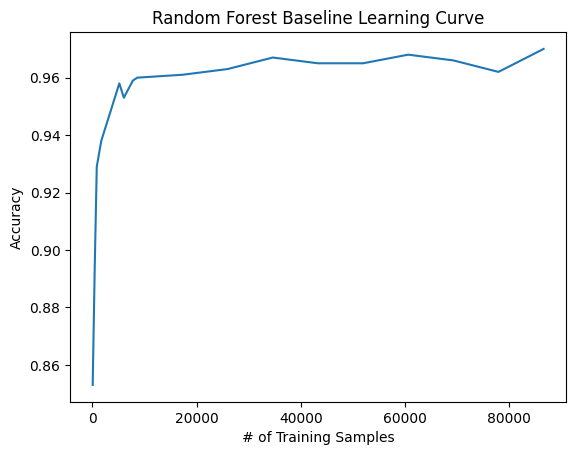

In [18]:
from matplotlib import pyplot as plt

with open('learning_curve.pkl', 'rb') as curve:
    curve = np.array(pickle.load(curve))

plt.plot(curve[:,0], curve[:,1])
plt.title('Random Forest Baseline Learning Curve')
plt.xlabel('# of Training Samples')
plt.ylabel('Accuracy')

Based on this learning curve, the model appears to be very quickly reaching a decent level of accuracy then not improving much past a certain point. This shows that it is not necessary to train the model on all samples in the dataset as this is unlikely to greatly improve performance. However, the model reaching accuracy levels of 97% is very unexpected. To further investigate this, a ten-fold stratified cross-validation will be performed. This will indicate whether the higher-than-expected accuracy is a result of the training and testing data selected or if it is the model learning from the data.

In [3]:
from sklearn.model_selection import cross_val_score, StratifiedKFold, KFold

vec = feature_extraction.text.TfidfVectorizer(ngram_range=(1,2), analyzer='word')
RF = pipeline.Pipeline([('vec',vec),('clf',RandomForestClassifier())])

cv = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
accuracy = cross_val_score(RF, df_test.iloc[:,0], df_test.iloc[:,1], cv=cv, scoring='accuracy')
mean_acc = np.mean(accuracy)

with open('cross_validation_score.pkl','wb') as save:
    pickle.dump(mean_acc, save)

with open('kfold_acc.pkl','wb') as save:
    pickle.dump(accuracy, save)

In [67]:
with open('cross_validation_score.pkl','rb') as score:
    mean_acc = pickle.load(score)

with open('kfold_acc.pkl','rb') as accuracy:
    accuracy = pickle.load(accuracy)

print("Accuracy for each fold:", accuracy)
print("Mean Accuracy:", mean_acc)

Accuracy for each fold: [0.99907611 0.99942257 0.99919159 0.99884513 0.99965354 0.99953805
 0.99942257 0.999307   0.999538   0.9994225 ]
Mean Accuracy: 0.9993417053643407


By reviewing the mean accuracy and the accuracy for each fold, it is shown that the model is performing consistently well on each training and testing set which means that the high accuracy was not a result of the training and testing set selected. The accuracy is still much higher than expected which is believed to be a result of the types of samples in the dataset. The dataset being used is a collection of Human-generated and AI-generated text from a multitude of sources. This may mean that samples that are near each other in the dataset are more similar and therefore the accuracy is higher. To combat this a section of data from the "final_train.csv" can be used as it is not connected to the samples in the "final_test.csv" and the model has not seen it. Below a random forest model trained on all samples in "final_test.csv" is tested on 2,000 samples from the "final_train.csv" dataset.

In [4]:
with open("RF_86587.pkl", "rb") as model:
    RF = pickle.load(model)

X_test = df_train.iloc[2000:4000,0]
y_test = df_train.iloc[2000:4000,1]

y_pred = RF.predict(X_test)
print("Accuracy on 2,000 samples from final_train.csv:", metrics.accuracy_score(y_test, y_pred))

Accuracy on 2,000 samples from final_train.csv: 0.974


This accuracy of 2,000 samples is much closer to what is expected from this model and indicates that final testing and validation should be done using data from the "final_train.csv" dataset. With this baseline model established for future comparasin, the focus is shifted to improving the model. As mentioned previously, additional features will be extracted from the text using various methods. The reason behind this is that it should give the model more data related to each text sample which should allow it to better generalize accross the features to tell the difference between human and AI writing.

## Feature Extraction
A majority of the features were extracted using the Natural Language ToolKit library or [NLTK](https://www.nltk.org/). The code used to do this is split across several files and is not the focus of the project so it is not included here but can be viewed on our [GitHub repository](https://github.com/cabbabbage/cs345_project). By utilizing the NLTK library, the following additional features were extracted: confidence, text-correctness, length, passive voice, noun, verb, adjective, adverb, pronoun, determiner, preposition, number, conjunction, interjection, sentences, and quotation. Additionally, by utilizing the [TextBlob](https://textblob.readthedocs.io/en/dev/) library, sentiment analysis of the data was also extracted as additional features. This data is composed of two columns each containing a value that ranges from -1 to 1 and represents the polarity and subjectivity of the text sample. However, these features may not improve accuracy or help the model generalize better and could cause the model performance to decrease. To determine this, feature analysis will be performed utilizing the random forest classifier's feature importance values and mean decrease in impurity or "Gini Importance" to determine the effect of the additional features on the model.

In [65]:
from textblob import TextBlob

sentiment_data = pd.DataFrame(columns=['polarity', 'subjectivity'])


for text in df_test.iloc[:,0]:
    blob = TextBlob(text)
    data = pd.DataFrame({'polarity' : [blob.sentiment.polarity], 'subjectivity' : [blob.sentiment.subjectivity]})
    sentiment_data = pd.concat([sentiment_data, data], ignore_index=True, axis=0)

sentiment_data.head()

with open('sentiment.pkl', 'wb') as save:
    pickle.dump(sentiment_data, save)

C:\Users\Josh\AppData\Local\Temp\ipykernel_16344\4028837249.py:9: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  sentiment_data = pd.concat([sentiment_data, data], ignore_index=True, axis=0)


In [2]:
with open('sentiment.pkl', 'rb') as sentiment:
    sentiment_data = pickle.load(sentiment)

In [3]:
df_features = pd.read_csv('added_features.csv')
confidence = df_features.iloc[:, 1]
correctness = df_features.iloc[:, 2]
length = df_features.iloc[:, 3]
passiveVoice = df_features.iloc[:, 5]
noun = df_features.iloc[:, 6]
verb = df_features.iloc[:, 7]
adjective = df_features.iloc[:, 8]
adverb = df_features.iloc[:, 9]
pronoun = df_features.iloc[:, 10]
determiner = df_features.iloc[:, 11]
preposition = df_features.iloc[:, 12]
number = df_features.iloc[:, 13]
conjunction = df_features.iloc[:, 14]
interjection = df_features.iloc[:, 15]
quotations = df_features.iloc[:, 16]
sentences = df_features.iloc[:, 17]
polarity = sentiment_data.iloc[:,0]
subjectivity = sentiment_data.iloc[:,1]

In [4]:
text = df_test.iloc[:,0]
labels = df_test.iloc[:,1]

features = pd.concat([confidence, correctness, length, passiveVoice, noun, verb, adjective, adverb, pronoun, determiner, preposition, number, conjunction, interjection, quotations, sentences, polarity, subjectivity], axis=1, ignore_index=True)


In [5]:
from scipy.sparse import hstack

vec = feature_extraction.text.TfidfVectorizer(ngram_range=(1,2), analyzer='word')
Train_text = df_test.iloc[0:69269]
Test_text = df_test.iloc[69269:86587]

X_train_text = vec.fit_transform(Train_text['text'])
X_test_text = vec.transform(Test_text['text'])

train_features = features.iloc[0:69269]
test_features = features.iloc[69269:86587]

X_train = hstack([X_train_text, train_features.values])
X_test = hstack([X_test_text, test_features.values])

y_train = labels.iloc[0:69269]
y_test = labels.iloc[69269:86587]

RF = RandomForestClassifier()
RF.fit(X_train, y_train)
with open("feature_RF.pkl", 'wb') as save:
    pickle.dump(RF, save)

y_pred = RF.predict(X_test)
accuracy = metrics.accuracy_score(y_test, y_pred)
print(accuracy)

0.9991338491742695


1426614


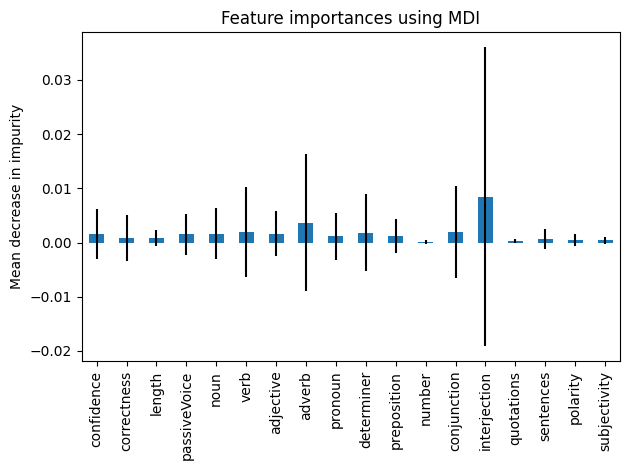

In [10]:
from sklearn.inspection import permutation_importance
from matplotlib import pyplot as plt

feature_names = ['confidence', 'correctness', 'length', 'passiveVoice', 'noun', 'verb', 'adjective', 'adverb', 'pronoun', 'determiner', 'preposition', 'number', 'conjunction', 'interjection', 'quotations', 'sentences', 'polarity', 'subjectivity']

importances = RF.feature_importances_
print(len(importances))
importances = RF.feature_importances_[1426596:1426614]
std = np.std([tree.feature_importances_[1426596:1426614] for tree in RF.estimators_], axis=0)

forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()
plt.show()

As can be seen in the graph above, many of the features don't have a particualarly high importance for the model. Additionaly, their importance accross the trees varies quite a lot. However, this is not neccessarily the most reliable way to determine feature importance as features can vary accross a random forest model. To properly determine feature importance would most likely require linguistic analysis by an expert on the different samples of text. However, this does give some insight into the features, for example correctness and passive voice are actually somewhat important in the model but their importance varies a lot accross the trees. From this analysis length, number, and sentences will be removed as features because both humans and LLMs can generate different length text so training this into the model could reduce accuracy by learning the training data too well which isn't representative of all texts and the number doesn't seem to have any impact on the model. With this complete the final dataframe for the additional features can be established.

In [13]:
final_features = pd.concat([confidence, correctness, passiveVoice, noun, verb, adjective, adverb, pronoun, determiner, preposition, conjunction, interjection, quotations, polarity, subjectivity], axis=1, ignore_index=True)

with open("features.pkl", 'wb') as save:
    pickle.dump(final_features, save)

## Model Selection
To improve from the baseline, several models will be trained and compared to determine which model to choose for final training, optimization, and comparasin. Three models will be tested, Random Forest, SVM, and Extremely Randomized Trees. The models will first be trained and tested using an 80-20 split then with 10-fold cross-validation.

In [14]:
with open("features.pkl", 'rb') as features:
    features_df = pickle.load(features)

with open('PandasDF_test_clean.pkl', 'rb') as data:
    df_test = pickle.load(data)

from scipy.sparse import hstack

vec = feature_extraction.text.TfidfVectorizer(ngram_range=(1,2), analyzer='word')
Train_text = df_test.iloc[0:69269]
Test_text = df_test.iloc[69269:86587]

X_train_text = vec.fit_transform(Train_text['text'])
X_test_text = vec.transform(Test_text['text'])

train_features = features_df.iloc[0:69269]
test_features = features_df.iloc[69269:86587]

X_train = hstack([X_train_text, train_features.values])
X_test = hstack([X_test_text, test_features.values])

y_train = labels.iloc[0:69269]
y_test = labels.iloc[69269:86587]

In [15]:
from sklearn import svm
SVM = svm.SVC()
RF = RandomForestClassifier()
ETC = ExtraTreesClassifier()

RF.fit(X_train, y_train)
with open("final_RF.pkl", 'wb') as save:
    pickle.dump(RF, save)

SVM.fit(X_train, y_train)
with open("final_SVM.pkl", 'wb') as save:
    pickle.dump(SVM, save)

ETC.fit(X_train, y_train)
with open("final_ETC.pkl", 'wb') as save:
    pickle.dump(ETC, save)

y_pred = SVM.predict(X_test)
accuracy = metrics.accuracy_score(y_test, y_pred)
print("SVM", accuracy)

y_pred = RF.predict(X_test)
accuracy = metrics.accuracy_score(y_test, y_pred)
print("RF", accuracy)

y_pred = ETC.predict(X_test)
accuracy = metrics.accuracy_score(y_test, y_pred)
print("ETC", accuracy)

SVM 0.6585633444970551
RF 0.9991338491742695
ETC 0.9995380528929437


Perform validation on the 2,000 sample dataset

## Training
perform a learning curve for the final model to determine how much data to train on and do a gidsearchcv to determine optimal hyperparameters.

## Analysis
Compare the baseline and the final model (k-fold, confusion matrix, accuracy, time)